# Plane Wave Fitting for Slowness Estimation
30th November,2021


plane wave fitting by iterating over all possible values of phi

In [1]:
# importing the requiered libraries

import numpy as np
import matplotlib.pyplot as plt
from sympy import *


In [2]:
### Testing out with 101 receivers placed in a line
n_rec=11# number of receivers, to be kept odd fro first run

rec_pos_act= np.zeros(shape =(n_rec,2))  # Assigning thr actual receiver position

v = 200 # m/s ### velocity of propagation (in sand)
freq=2 #Hz, max recorded frequency
lamda=v/freq# wavelength
d=2000#m,  l=2000m  > 10 times lamda 
a=np.random.randint(-10,10)
b=np.random.randint(-10,10)

src=(b*d,a*d)

rec_pos_act=np.random.normal(0,500,size=(n_rec,2))
#for i in range(0,n_rec):
 #   rec_pos_act[i,1]=0
  #  rec_pos_act[i,0]=(i-(n_rec-1)/2)*5 #first receievr at (-50,0) last at (50,0), all in line, distance 5 between them 
for i in range(0,n_rec):
    rec_pos_act[i,0]=100*cos(i*2*np.pi/n_rec)
    rec_pos_act[i,1]=100*sin(i*2*np.pi/n_rec)
###rec_pos_act[:,:] = 0# The deployer is at origin. 
#noise_r = np.random.normal(loc=0.0,scale =100,size = (101,2))
t_rec_ideal = np.zeros(shape =(n_rec,))  # time recorded in each receiver; form: (index of receiver,time) 
t_noise=np.random.normal(0,5/(v),size=(n_rec,))
rec_pos_noise=np.random.normal(0,5,size=(n_rec,2))

rec_pos_mes= rec_pos_act + rec_pos_noise  # rec_pos_mes stores[(x1,y1),(x2,y2),..]

for i in range (0,n_rec):
    t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_mes[0:n_rec,0]-src[0])**2 + (rec_pos_mes[0:n_rec,1]-src[1])**2)/v


t_Rec_real=t_rec_ideal + t_noise
### t_Rec_real has form [[rec1 recording], [rec2 recording]]
t_diff=np.zeros(shape=(n_rec,))
for i in range(0,n_rec):
    t_diff[i]=t_rec_ideal[i]-t_rec_ideal[0]


In [3]:
print(t_Rec_real)


[71.02232448 70.81461859 70.49847003 70.32472302 70.20991167 70.23422641
 70.48679277 70.69758871 71.02246166 71.18824111 71.23030678]


In [4]:
def sum_of_errors(s_x,s_y,n_rec,rec_loc,time_diff):
    soe=0
    for i in range (0,n_rec):
        soe+=(time_diff[i]-s_x*rec_loc[i,0]-s_y*rec_loc[i,1])**2
    return soe    

In [5]:
def estimate_slowness(v,n_rec,rec_loc,time_diff):
    phi_estimate=0
    error=10000
    phi_range = np.linspace(0,2*np.pi,200000)
    for phi in phi_range :
            soe=sum_of_errors(-np.sin(phi)/v,-np.cos(phi)/v,n_rec,rec_loc,time_diff)  
            #print(s_x_temp,s_y_temp)
            #print(soe)
            #print(s_x_temp,s_y_temp
            if ( error>soe):
                error =soe
                phi_estimated=phi
    if (sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)<error) :
        error=sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)
        phi_estimated=np.pi-phi_estimated
    
        phi_estimated=phi_estimated-2*np.pi
    return (phi_estimated,error)  

In [6]:
phi_actual=np.arctan(src[0]/src[1])
print("actual angle: ", phi_actual)
phi_estimated,final_error=estimate_slowness(v,n_rec,rec_pos_mes,t_diff)
print("phi_estimated :",phi_estimated," final_error: ", final_error)

print("pi- phi_estimated :",np.pi-phi_estimated)



actual angle:  -0.7853981633974483
phi_estimated : 5.499479685286967  final_error:  1.2000789704265444
pi- phi_estimated : -2.3578870316971736


In [7]:
print(" difference in backazimuth: ",np.pi-phi_estimated-phi_actual," percentage error : ",((np.pi-phi_estimated)/phi_actual-1)*100,"%"  )
print(" difference in backazimuth: ",phi_estimated-phi_actual," percentage error : ",((phi_estimated)/phi_actual-1)*100,"%"  )

 difference in backazimuth:  -1.5724888682997253  percentage error :  200.21550107750534 %
 difference in backazimuth:  6.284877848684415  percentage error :  -800.2155010775053 %


In [8]:
sum_of_errors(-np.sin(phi_actual)/v,-np.cos(phi_actual)/v,n_rec,rec_pos_mes,t_diff)

1.2000830967390288

In [9]:
sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_actual)/v,n_rec,rec_pos_mes,t_diff)

4.097538915011398

In [10]:
x=np.linspace(0,2*np.pi,2000)
y=np.zeros(shape=(2000,))
for i in range(0,2000):
    y[i]=sum_of_errors(-sin(x[i])/v,-cos(x[i])/v,n_rec,rec_pos_mes,t_diff)

Text(0, 0.5, 'error in arbitary units')

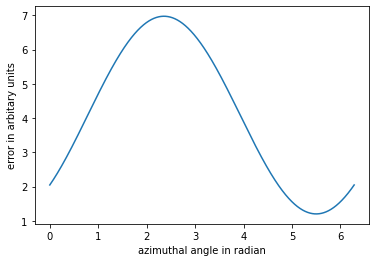

In [11]:
plt.plot(x,y)
plt.xlabel("azimuthal angle in radian")
plt.ylabel("error in arbitary units")

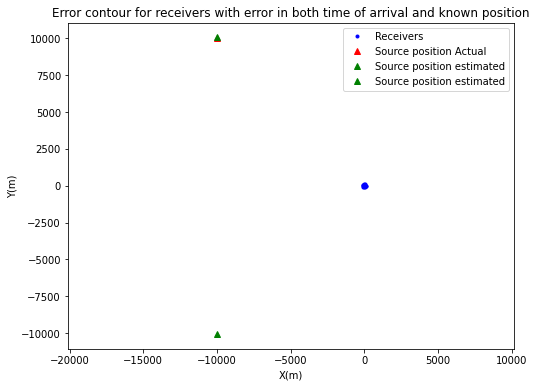

diff in location:  66.78624428854737
diff in location:  20061.077316036382


In [12]:
x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position

rec_pos_modified = np.zeros_like(rec_pos_act)
rec_pos_modified[:] = rec_pos_act[:]  # Can modify later if required

plt.figure(figsize=(8,6))
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(src[0],src[1],'r^',label='Source position Actual')
d=v*t_Rec_real[0]
plt.plot(d*np.sin(phi_estimated),d*np.cos(phi_estimated),'g^',label='Source position estimated')

plt.plot(d*np.sin(np.pi-phi_estimated),d*np.cos(np.pi-phi_estimated),'g^',label='Source position estimated')
plt.plot()
plt.legend()
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')

plt.title('Error contour for receivers with error in both time of arrival and known position')
plt.show()
print("diff in location: " ,  np.sqrt((src[0]-d*np.sin(phi_estimated))**2+(src[1]-d*np.cos(phi_estimated))**2))
print("diff in location: " , np.sqrt((src[0]-d*np.sin(np.pi-phi_estimated))**2+(src[1]-d*np.cos(np.pi-phi_estimated))**2))
      

Cause of the error is because the estimated position assumes that first receiver (at index 0) is at origin ,\\
whereas this is not the case for circular configuration

Configurations tried so far:
linear,
gaussian(negative results),
circular

Noise introduced in position has standard deviation 5m; and that in time has standard deviation 5/v